In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
import re
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore')

C:\Users\alaba\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
cols=pd.read_csv('VariableDescription.csv')

In [3]:
pd.set_option('display.max_columns', None)

# Columns

In [4]:
cols

,Variable Name,Variable Label,Answer Label
0,child_id,Unique child ID,Open ended
1,data_year,Year data was collected,Open ended
2,child_date,ELOM date,Open ended
3,child_age,Child age in months,Open ended
4,child_enrolment_date,Date enrolled in ELP,Open ended
...,...,...,...
676,child_attends,Does child attend an ECD programme?,NaN
677,child_attendance,How many days per week does the child attend t...,NaN
678,child_languages,Child home language(s),NaN
679,pri_fees_amount_pv,Facility monthly fee (present value),NaN


In [5]:
cols[cols['Variable Name']=='child_stunted']

,Variable Name,Variable Label,Answer Label
14,child_stunted,Stunted indicator,NaN


Index(['child_age', 'child_years_in_programme', 'child_height',
       'child_observe_attentive', 'child_observe_concentrated',
       'child_observe_diligent', 'child_gender', 'child_stunted', 'id_mn_best',
       'prov_best', 'id_dc_best', 'dc_best', 'mn_best', 'id_enumerator',
       'id_facility', 'pra_ind', 'teacher_social_total',
       'teacher_selfcare_total', 'teacher_emotional_total', 'hle_ind',
       'id_ward', 'census', 'quintile', 'language_child', 'sef_ind',
       'language_match', 'gps_ind', 'ses_proxy', 'id_facility_n', 'id_mn_n',
       'id_prov_n', 'child_year', 'child_month', 'child_day_name'],
      dtype='object')

In [6]:
train.id_enumerator.value_counts()

id_enumerator
1324.0     89
1300.0     87
2674.0     87
20060.0    85
502.0      84
           ..
20018.0     1
213.0       1
138.0       1
205.0       1
132.0       1
Name: count, Length: 212, dtype: int64

# Train Set

In [7]:
# Preview train
train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_gender,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_except

In [8]:
D={c:train[c].isnull().sum() for c in train.columns}
L=list()
perc=0.3
for col in D:
    if D[col]>8585*perc :
        train.drop(columns=[col],inplace=True)
        L.append(col)
train.head()

,child_id,data_year,child_date,child_age,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,id_enumerator,id_facility,pra_ind,teacher_social_total,teacher_selfcare_total,teacher_social_met,teacher_emotional_total,teacher_emotional_met,teacher_selfcare_met,hle_ind,id_ward,id_prov,census,quintile,language_child,language_assessment,sef_ind,language_match,elp_ind,gps_ind,pre_covid,ses_proxy,quintile_used,id_facility_n,id_mn_n,id_dc_n,id_prov_n,target
0,ID_SYSJ2FM0D,2022.0,2022-02-03,59.000000,NaN,NaN,Sometimes,Sometimes,Sometimes,Sometimes,4.0,Female,2017-02-06,NaN,NaN,50-59 months,GT421,GAUTENG,DC42,SEDIBENG,EMFULENI,20005.0,761.0,No,0.0,NaN,Does not meet standard,NaN,Does not meet standard,NaN,No,74201039.0,GT,No,2.0,Sesotho,Sesotho,Yes,1.0,No,Yes,Post COVID,2.0,Yes,7.0,107.0,134.0,1051.0,51.500000
1,ID_J5BTFOZR3,2019.0,NaN,60.163933,1st year in the programme,103.000000,Sometimes,Almost never,Sometimes,Often,4.0,Female,NaN,-1.356791,Normal,60-69 months,NaN,KWAZULU-NATAL,DC22,UMGUNGUNDLOVU,NaN,NaN,458.0,No,12.0,4.0,Does not meet standard,7.0,Does not meet standard,Meets the standard,No,NaN,KZN,No,4.0,isiZulu,isiZulu,Yes,1.0,No,No,Pre-COVID,4.0,Yes,24.0,NaN,367.0,1832.0,55.869999
2,ID_R00SN7AUD,2022.0,2022-03-11,69.000000,NaN,108.400002,Often,Often,Sometimes,Often,7.0,Male,2016-05-24,-1.250863,Normal,60-69 months,CPT,WESTERN CAPE,CPT,CITY OF CAPE TOWN,CITY OF CAPE TOWN,20001.0,925.0,No,15.0,4.0,NaN,9.0,NaN,Meets the standard,No,19100085.0,WC,No,4.0,Afrikaans,Afrikaans,No,1.0,Yes,Yes,Post COVID,1.0,No,8.0,1448.0,1448.0,3214.0,47.520000
3,ID_BSSK60PAZ,2021.0,2021-10-13,53.000000,1st year in the programme,98.099998,Almost always,Almost always,Sometimes,Often,9.0,Male,2017-05-08,-1.830364,Normal,50-59 months,WC025,WESTERN CAPE,DC2,CAPE WINELANDS,BREEDE VALLEY,2689.0,308.0,Yes,18.0,4.0,Meets the standard,12.0,Meets the standard,Meets the standard,No,10205018.0,WC,Yes,1.0,isiXhosa,isiXhosa,Yes,1.0,Yes,Yes,Post COVID,3.0,No,4.0,76.0,629.0,3214.0,58.599998
4,ID_IZTY6TC4D,2021.0,2021-10-13,57.000000,2nd year in programme,114.000000,Almost always,Almost always,Almost always,Almost always,12.0,Female,2016-12-19,1.329264,Normal,50-59 months,KZN293,KWAZULU-NATAL,DC29,ILEMBE,NDWEDWE,542.0,1749.0,Yes,24.0,4.0,Meets the standard,12.0,Meets the standard,Meets the standard,No,52903010.0,KZN,No,1.0,isiZulu,isiZulu,Yes,1.0,Yes,Yes,Post COVID,1.0,No,1.0,71.0,315.0,1832.0,76.599998


# Deleting Date/Year Columns/Extracting Date/


train.drop(columns=['id_mn_best'],inplace=True)
test.drop(columns=['id_mn_best'],inplace=True)

In [9]:
pattern = '.*(date|year|dob).*'
# Use the filter method to select columns matching the pattern
dell= train.filter(regex=pattern).columns

In [10]:
train.drop(columns=[c for c in dell if (c!='child_date') and  (c!='child_years_in_programme')],inplace=True)

In [11]:
dell

Index(['data_year', 'child_date', 'child_years_in_programme', 'child_dob'], dtype='object')

In [12]:
from datetime import date
#Transform string to date
train['child_date'] = pd.to_datetime(train.child_date, format="%Y-%m-%d")
#Extracting Year
train['child_year'] = train['child_date'].dt.year
#Extracting Month
train['child_month'] = train['child_date'].dt.month
#Extracting the weekday name of the date
train['child_day_name'] = train['child_date'].dt.day_name()


train.drop(columns=['child_date'],inplace=True)
train.head()

,child_id,child_age,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_zha,child_stunted,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,id_enumerator,id_facility,pra_ind,teacher_social_total,teacher_selfcare_total,teacher_social_met,teacher_emotional_total,teacher_emotional_met,teacher_selfcare_met,hle_ind,id_ward,id_prov,census,quintile,language_child,language_assessment,sef_ind,language_match,elp_ind,gps_ind,pre_covid,ses_proxy,quintile_used,id_facility_n,id_mn_n,id_dc_n,id_prov_n,target,child_year,child_month,child_day_name
0,ID_SYSJ2FM0D,59.000000,NaN,NaN,Sometimes,Sometimes,Sometimes,Sometimes,4.0,Female,NaN,NaN,50-59 months,GT421,GAUTENG,DC42,SEDIBENG,EMFULENI,20005.0,761.0,No,0.0,NaN,Does not meet standard,NaN,Does not meet standard,NaN,No,74201039.0,GT,No,2.0,Sesotho,Sesotho,Yes,1.0,No,Yes,Post COVID,2.0,Yes,7.0,107.0,134.0,1051.0,51.500000,2022.0,2.0,Thursday
1,ID_J5BTFOZR3,60.163933,1st year in the programme,103.000000,Sometimes,Almost never,Sometimes,Often,4.0,Female,-1.356791,Normal,60-69 months,NaN,KWAZULU-NATAL,DC22,UMGUNGUNDLOVU,NaN,NaN,458.0,No,12.0,4.0,Does not meet standard,7.0,Does not meet standard,Meets the standard,No,NaN,KZN,No,4.0,isiZulu,isiZulu,Yes,1.0,No,No,Pre-COVID,4.0,Yes,24.0,NaN,367.0,1832.0,55.869999,NaN,NaN,NaN
2,ID_R00SN7AUD,69.000000,NaN,108.400002,Often,Often,Sometimes,Often,7.0,Male,-1.250863,Normal,60-69 months,CPT,WESTERN CAPE,CPT,CITY OF CAPE TOWN,CITY OF CAPE TOWN,20001.0,925.0,No,15.0,4.0,NaN,9.0,NaN,Meets the standard,No,19100085.0,WC,No,4.0,Afrikaans,Afrikaans,No,1.0,Yes,Yes,Post COVID,1.0,No,8.0,1448.0,1448.0,3214.0,47.520000,2022.0,3.0,Friday
3,ID_BSSK60PAZ,53.000000,1st year in the programme,98.099998,Almost always,Almost always,Sometimes,Often,9.0,Male,-1.830364,Normal,50-59 months,WC025,WESTERN CAPE,DC2,CAPE WINELANDS,BREEDE VALLEY,2689.0,308.0,Yes,18.0,4.0,Meets the standard,12.0,Meets the standard,Meets the standard,No,10205018.0,WC,Yes,1.0,isiXhosa,isiXhosa,Yes,1.0,Yes,Yes,Post COVID,3.0,No,4.0,76.0,629.0,3214.0,58.599998,2021.0,10.0,Wednesday
4,ID_IZTY6TC4D,57.000000,2nd year in programme,114.000000,Almost always,Almost always,Almost always,Almost always,12.0,Female,1.329264,Normal,50-59 months,KZN293,KWAZULU-NATAL,DC29,ILEMBE,NDWEDWE,542.0,1749.0,Yes,24.0,4.0,Meets the standard,12.0,Meets the standard,Meets the standard,No,52903010.0,KZN,No,1.0,isiZulu,isiZulu,Yes,1.0,Yes,Yes,Post COVID,1.0,No,1.0,71.0,315.0,1832.0,76.599998,2021.0,10.0,Wednesday


In [13]:
#Transform string to date
test['child_date'] = pd.to_datetime(test.child_date, format="%Y-%m-%d")
#Extracting Year
test['child_year'] = test['child_date'].dt.year
#Extracting Month
test['child_month'] = test['child_date'].dt.month
#Extracting the weekday name of the date
test['child_day_name'] = test['child_date'].dt.day_name()

test.drop(columns=['child_date'],inplace=True)
test.head()

,child_id,data_year,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_gender,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_exceptions,pri_fe

In [14]:
train.drop(columns=['child_id'],inplace=True)

In [15]:
train.head()

,child_age,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_zha,child_stunted,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,id_enumerator,id_facility,pra_ind,teacher_social_total,teacher_selfcare_total,teacher_social_met,teacher_emotional_total,teacher_emotional_met,teacher_selfcare_met,hle_ind,id_ward,id_prov,census,quintile,language_child,language_assessment,sef_ind,language_match,elp_ind,gps_ind,pre_covid,ses_proxy,quintile_used,id_facility_n,id_mn_n,id_dc_n,id_prov_n,target,child_year,child_month,child_day_name
0,59.000000,NaN,NaN,Sometimes,Sometimes,Sometimes,Sometimes,4.0,Female,NaN,NaN,50-59 months,GT421,GAUTENG,DC42,SEDIBENG,EMFULENI,20005.0,761.0,No,0.0,NaN,Does not meet standard,NaN,Does not meet standard,NaN,No,74201039.0,GT,No,2.0,Sesotho,Sesotho,Yes,1.0,No,Yes,Post COVID,2.0,Yes,7.0,107.0,134.0,1051.0,51.500000,2022.0,2.0,Thursday
1,60.163933,1st year in the programme,103.000000,Sometimes,Almost never,Sometimes,Often,4.0,Female,-1.356791,Normal,60-69 months,NaN,KWAZULU-NATAL,DC22,UMGUNGUNDLOVU,NaN,NaN,458.0,No,12.0,4.0,Does not meet standard,7.0,Does not meet standard,Meets the standard,No,NaN,KZN,No,4.0,isiZulu,isiZulu,Yes,1.0,No,No,Pre-COVID,4.0,Yes,24.0,NaN,367.0,1832.0,55.869999,NaN,NaN,NaN
2,69.000000,NaN,108.400002,Often,Often,Sometimes,Often,7.0,Male,-1.250863,Normal,60-69 months,CPT,WESTERN CAPE,CPT,CITY OF CAPE TOWN,CITY OF CAPE TOWN,20001.0,925.0,No,15.0,4.0,NaN,9.0,NaN,Meets the standard,No,19100085.0,WC,No,4.0,Afrikaans,Afrikaans,No,1.0,Yes,Yes,Post COVID,1.0,No,8.0,1448.0,1448.0,3214.0,47.520000,2022.0,3.0,Friday
3,53.000000,1st year in the programme,98.099998,Almost always,Almost always,Sometimes,Often,9.0,Male,-1.830364,Normal,50-59 months,WC025,WESTERN CAPE,DC2,CAPE WINELANDS,BREEDE VALLEY,2689.0,308.0,Yes,18.0,4.0,Meets the standard,12.0,Meets the standard,Meets the standard,No,10205018.0,WC,Yes,1.0,isiXhosa,isiXhosa,Yes,1.0,Yes,Yes,Post COVID,3.0,No,4.0,76.0,629.0,3214.0,58.599998,2021.0,10.0,Wednesday
4,57.000000,2nd year in programme,114.000000,Almost always,Almost always,Almost always,Almost always,12.0,Female,1.329264,Normal,50-59 months,KZN293,KWAZULU-NATAL,DC29,ILEMBE,NDWEDWE,542.0,1749.0,Yes,24.0,4.0,Meets the standard,12.0,Meets the standard,Meets the standard,No,52903010.0,KZN,No,1.0,isiZulu,isiZulu,Yes,1.0,Yes,Yes,Post COVID,1.0,No,1.0,71.0,315.0,1832.0,76.599998,2021.0,10.0,Wednesday


# Ordinal Encoding

In [16]:
train_test=pd.concat([train,test])

In [17]:
cat_cols = train.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()
encoder.fit(train_test[cat_cols])
train[cat_cols] = encoder.transform(train[cat_cols])
test[cat_cols] = encoder.transform(test[cat_cols])
train.head()

,child_age,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_zha,child_stunted,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,id_enumerator,id_facility,pra_ind,teacher_social_total,teacher_selfcare_total,teacher_social_met,teacher_emotional_total,teacher_emotional_met,teacher_selfcare_met,hle_ind,id_ward,id_prov,census,quintile,language_child,language_assessment,sef_ind,language_match,elp_ind,gps_ind,pre_covid,ses_proxy,quintile_used,id_facility_n,id_mn_n,id_dc_n,id_prov_n,target,child_year,child_month,child_day_name
0,59.000000,NaN,NaN,3.0,3.0,3.0,3.0,4.0,0.0,NaN,NaN,0.0,39.0,2.0,35.0,35.0,28.0,20005.0,761.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,74201039.0,2.0,0.0,2.0,4.0,4.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,7.0,107.0,134.0,1051.0,51.500000,2022.0,2.0,4.0
1,60.163933,0.0,103.000000,3.0,1.0,3.0,2.0,4.0,0.0,-1.356791,1.0,1.0,NaN,3.0,14.0,39.0,NaN,NaN,458.0,0.0,12.0,4.0,0.0,7.0,0.0,1.0,0.0,NaN,3.0,0.0,4.0,10.0,11.0,1.0,1.0,0.0,0.0,1.0,4.0,1.0,24.0,NaN,367.0,1832.0,55.869999,NaN,NaN,NaN
2,69.000000,NaN,108.400002,2.0,2.0,3.0,2.0,7.0,1.0,-1.250863,1.0,1.0,1.0,9.0,1.0,8.0,11.0,20001.0,925.0,0.0,15.0,4.0,NaN,9.0,NaN,1.0,0.0,19100085.0,8.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,8.0,1448.0,1448.0,3214.0,47.520000,2022.0,3.0,0.0
3,53.000000,0.0,98.099998,0.0,0.0,3.0,2.0,9.0,1.0,-1.830364,1.0,0.0,144.0,9.0,11.0,5.0,6.0,2689.0,308.0,1.0,18.0,4.0,1.0,12.0,1.0,1.0,0.0,10205018.0,8.0,1.0,1.0,9.0,10.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,4.0,76.0,629.0,3214.0,58.599998,2021.0,10.0,6.0
4,57.000000,1.0,114.000000,0.0,0.0,0.0,0.0,12.0,0.0,1.329264,1.0,0.0,68.0,3.0,21.0,21.0,98.0,542.0,1749.0,1.0,24.0,4.0,1.0,12.0,1.0,1.0,0.0,52903010.0,3.0,0.0,1.0,10.0,11.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,71.0,315.0,1832.0,76.599998,2021.0,10.0,6.0


cat_cols = train.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()
encoder.fit(train[cat_cols])
train[cat_cols] = encoder.transform(train[cat_cols])
test[cat_cols] = encoder.transform(test[cat_cols])
train.head()

In [18]:
train['child_years_in_programme']=train['child_years_in_programme'].fillna(3.0)
test['child_years_in_programme']=test['child_years_in_programme'].fillna(3.0)

In [19]:
cat_cols

Index(['child_years_in_programme', 'child_observe_attentive',
       'child_observe_concentrated', 'child_observe_diligent',
       'child_observe_interested', 'child_gender', 'child_stunted',
       'child_age_group', 'id_mn_best', 'prov_best', 'id_dc_best', 'dc_best',
       'mn_best', 'pra_ind', 'teacher_social_met', 'teacher_emotional_met',
       'teacher_selfcare_met', 'hle_ind', 'id_prov', 'census',
       'language_child', 'language_assessment', 'sef_ind', 'elp_ind',
       'gps_ind', 'pre_covid', 'quintile_used', 'child_day_name'],
      dtype='object')

# HERE!!!!

## Replace Naan values of the dates/language_match

In [20]:
train['child_day_name']=train['child_day_name'].fillna(train['child_day_name'].median())
train['child_month']=train['child_month'].fillna(train['child_month'].median())
train['child_year']=train['child_year'].fillna(train['child_year'].median())

test['child_day_name']=test['child_day_name'].fillna(test['child_day_name'].median())
test['child_month']=test['child_month'].fillna(test['child_month'].median())
test['child_year']=test['child_year'].fillna(test['child_year'].median())

train['teacher_emotional_total']=train['teacher_emotional_total'].fillna(5.0) #child_observe_total
test['teacher_emotional_total']=test['teacher_emotional_total'].fillna(5.0)

train['child_stunted']=train['child_stunted'].fillna(1.0) 
test['child_stunted']=test['child_stunted'].fillna(1.0) #language_child

train['child_observe_total']=train['child_observe_total'].fillna(12.0) #child_observe_total
test['child_observe_total']=test['child_observe_total'].fillna(12.0)

In [21]:
train[train['id_enumerator']<0].id_enumerator

Series([], Name: id_enumerator, dtype: float64)

# Simple  Imputer

In [22]:

imputer = SimpleImputer(strategy='mean')
df0=train[cat_cols]
imputer.fit(df0)
X_imputed0 = imputer.transform(df0)
res0=pd.DataFrame(X_imputed0,columns=df0.columns)
train[cat_cols]=res0[cat_cols]

imputer = SimpleImputer(strategy='mean')
df1=test[cat_cols]
imputer.fit(df1)
X_imputed1 = imputer.transform(df1)
res1=pd.DataFrame(X_imputed1,columns=df1.columns)
test[cat_cols]=res1[cat_cols]

#############################################################################################################


# Test Set

In [23]:
# Preview test
test.head()

,child_id,data_year,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_dob,child_zha,child_stunted,child_attends,child_attendance,child_languages,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,ward_best,id_enumerator,id_facility,pqa_date,pqa_class_age,pqa_class_age_1,pqa_class_age_2,pqa_class_age_3,pqa_class_age_4,pqa_class_age_5,pqa_class_age_6,pqa_class_assistants,pqa_environment_areas,pqa_environment_variety,pqa_environment_appropriate,pqa_environment_accessible,pqa_environment_open,pqa_environment_outdoor,pqa_score_environment,pqa_assessment_observation,pqa_assessment_systematic,pqa_score_assessment,pqa_relationships_peers,pqa_relationships_staff,pqa_relationships_acknowledge,pqa_relationships_discipline,pqa_score_relationships,pqa_curriculum_ncf,pqa_curriculum_plan,pqa_curriculum_balance,pqa_curriculum_numeracy,pqa_curriculum_literacy,pqa_score_curriculum,pqa_teaching_choice,pqa_teaching_engagement,pqa_teaching_participation,pqa_teaching_questions,pqa_teaching_support,pqa_score_teaching,pqa_class,pra_free_play,pra_free_play_outdoor,pra_groupings,pra_groupings_1,pra_groupings_2,pra_groupings_3,pra_groupings_4,pra_groupings_5,pra_engaged,pra_agency_choice,pra_agency_explore,pra_agency_questions,pra_agency_understand,pra_agency_play,pra_agency_learn,pra_agency_order,pra_plans,pra_plans_1,pra_plans_2,pra_plans_3,pra_plans_0,pra_gender,pra_experience,pra_class_present,pra_date,pra_class_size,pra_class_attendance,pra_class_attendance_precovid,pra_class_size_large,pra_cohort,pra_cohort_0,pra_cohort_1,pra_cohort_2,pra_cohort_3,pra_cohort_4,pra_cohort_5,pra_cohort_6,pra_class_language,pra_plan_4yrs,pra_plan_4yrs_1,pra_plan_4yrs_2,pra_plan_4yrs_3,pra_plan_4yrs_4,pra_plan_4yrs_97,pra_plan_ncf,pra_plan_5yrs,pra_plan_5yrs_1,pra_plan_5yrs_2,pra_plan_5yrs_3,pra_plan_5yrs_4,pra_plan_5yrs_5,pra_plan_5yrs_97,pra_plan_approved,pra_plan_4yrsother,pra_plan_5yrsother,pra_job,pra_clearance_police,pra_clearance_ncp,pra_salary,pra_paid,pra_breadwinner,pra_hhsize,pra_education,pra_qualification,pra_qualification_1,pra_qualification_2,pra_qualification_3,pra_qualification_4,pra_qualification_5,pra_qualification_6,pra_qualification_7,pra_qualification_97,pra_qualification_0,pra_educationother,pra_qualificationother,pra_previous,pra_ncf_training,pra_ncf_trainer,pra_ncf_trainer_1,pra_ncf_trainer_2,pra_ncf_trainer_3,pra_ncf_trainer_4,pra_ncf_trainer_5,pra_ncf_trainer_97,pra_ncf_trainerother,pra_learnership,pra_training,pra_training_1,pra_training_2,pra_training_3,pra_training_4,pra_training_5,pra_training_6,pra_training_0,pra_special_training,pra_special_referrals,pra_online_training,pra_online_training_details,pra_motivate_support,pra_motivate_recognition,pra_motivate_mentoring,pra_shape,pra_measure_rectangle_length,pra_measure_rectangle_width,pra_class_space,pra_class_space_small,pra_class_space_large,pra_ind,pra_language,pri_mobile,pri_school,pri_holidays,pri_days,pri_time_open_hours,pri_time_open_minutes,pri_time_close_hours,pri_time_close_minutes,pri_calc_time_open,pri_calc_time_close,pri_year,pri_separate,pri_language,pri_language_1,pri_language_2,pri_language_3,pri_language_4,pri_language_5,pri_language_6,pri_language_7,pri_language_8,pri_language_9,pri_language_10,pri_language_11,pri_language_97,pri_languageother,pri_toys,pri_aftercare,pri_fees,pri_fees_amount,pri_fees_free,pri_facilities,pri_land,pri_facilitiesother,pri_landother,pri_fundingother,pri_bank,pri_transport,pri_meal,pri_meal_1,pri_meal_3,pri_meal_4,pri_meal_2,pri_registered_partial,pri_registered_programme,pri_registered_npo,pri_registered_dsd,pri_subsidy,pri_network,pri_dsd_year,pri_capacity,pri_reason_register_year,pri_attendance_usual,pri_precovid_attendance,pri_kitchen,pri_funding_6,pri_funding_7,pri_funding_donations,pri_funding_97,pri_attendance,pri_fees_exceptions,pri_fe

In [24]:
child_id=test.child_id
test.drop(columns=['child_id'],inplace=True)

In [25]:
test.drop(columns=L,inplace=True)
test.drop(columns=[c for c in dell if (c!='child_date') and (c!='child_years_in_programme')],inplace=True)

In [26]:
test.head()

,child_age,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_zha,child_stunted,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,id_enumerator,id_facility,pra_ind,teacher_social_total,teacher_selfcare_total,teacher_social_met,teacher_emotional_total,teacher_emotional_met,teacher_selfcare_met,hle_ind,id_ward,id_prov,census,quintile,language_child,language_assessment,sef_ind,language_match,elp_ind,gps_ind,pre_covid,ses_proxy,quintile_used,id_facility_n,id_mn_n,id_dc_n,id_prov_n,child_year,child_month,child_day_name
0,57.000000,1.0,108.0,0.0,2.0,0.0,0.0,11.0,0.0,0.038152,1.0,0.0,84.000000,4.0,28.000000,6.000000,112.00000,1732.0,1878.0,1.000000,24.0,4.0,1.0,12.0,1.0,1.000000,0.0,93504008.0,4.00000,1.0,3.0,3.000000,3.0,1.0,1.0,1.00000,1.0,0.0,3.0,0.00000,3.0,74.0,296.0,1236.0,2021.0,9.0,1.0
1,54.000000,0.0,105.0,0.0,0.0,2.0,0.0,11.0,0.0,-0.259006,1.0,0.0,57.000000,3.0,17.000000,1.000000,100.00000,484.0,268.0,1.000000,22.0,4.0,1.0,12.0,1.0,1.000000,0.0,52502021.0,3.00000,1.0,1.0,10.000000,11.0,1.0,1.0,1.00000,1.0,0.0,2.0,0.00000,4.0,13.0,13.0,1832.0,2021.0,10.0,4.0
2,57.000000,3.0,101.5,2.0,2.0,2.0,2.0,8.0,1.0,-1.507299,1.0,0.0,103.000000,5.0,25.000000,13.000000,105.00000,20060.0,1683.0,1.000000,0.0,NaN,0.0,5.0,0.0,0.845704,0.0,83204020.0,5.00000,1.0,1.0,10.000000,11.0,1.0,1.0,1.00000,1.0,0.0,3.0,0.00000,26.0,117.0,366.0,999.0,2021.0,5.0,1.0
3,59.334702,2.0,NaN,0.0,0.0,0.0,2.0,11.0,0.0,NaN,1.0,0.0,66.474038,1.0,21.593342,19.795127,60.84647,43.0,2222.0,0.640764,19.0,4.0,1.0,10.0,1.0,1.000000,0.0,41803007.0,4.55347,1.0,NaN,5.749753,4.0,1.0,1.0,0.67435,1.0,0.0,2.0,0.36716,NaN,NaN,NaN,NaN,2022.0,9.0,0.0
4,54.000000,0.0,103.5,2.0,2.0,2.0,0.0,9.0,1.0,-0.717292,1.0,0.0,148.000000,9.0,33.000000,18.000000,44.00000,572.0,534.0,1.000000,15.0,3.0,0.0,7.0,0.0,0.000000,0.0,10402006.0,8.00000,1.0,1.0,0.000000,0.0,1.0,1.0,1.00000,1.0,0.0,1.0,0.00000,4.0,39.0,123.0,3214.0,2021.0,10.0,5.0


# Delete Outliers

In [27]:
Q1 = train['target'].quantile(0.25)
Q3 = train['target'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.4 * IQR
lower_limit = Q1 - 1.6 * IQR
#train = train.drop(index=(train['target'] >=upper_limit).index)

In [28]:
LL=list(train[(train['target']>=upper_limit)|(train['target']<=lower_limit)].index)
LL

[30,
 278,
 1423,
 1529,
 1773,
 2064,
 2723,
 2873,
 2921,
 4084,
 4197,
 4632,
 4906,
 4907,
 5434,
 6206,
 6832,
 7156,
 7724,
 7729,
 7988,
 8269]

In [29]:
train = train.drop(index=LL)

In [30]:
X = train.fillna(train.mean())
test = test.fillna(test.mean())
X.head()

,child_age,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total,child_gender,child_zha,child_stunted,child_age_group,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,id_enumerator,id_facility,pra_ind,teacher_social_total,teacher_selfcare_total,teacher_social_met,teacher_emotional_total,teacher_emotional_met,teacher_selfcare_met,hle_ind,id_ward,id_prov,census,quintile,language_child,language_assessment,sef_ind,language_match,elp_ind,gps_ind,pre_covid,ses_proxy,quintile_used,id_facility_n,id_mn_n,id_dc_n,id_prov_n,target,child_year,child_month,child_day_name
0,59.000000,3.0,106.940060,3.0,3.0,3.0,3.0,4.0,0.0,-0.368511,1.0,0.0,39.00000,2.0,35.0,35.0,28.00000,20005.000000,761.0,0.0,0.0,3.801508,0.000000,5.0,0.000000,0.841009,0.0,7.420104e+07,2.0,0.0,2.0,4.0,4.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,7.0,107.000000,134.0,1051.0,51.500000,2022.0,2.0,4.0
1,60.163933,0.0,103.000000,3.0,1.0,3.0,2.0,4.0,0.0,-1.356791,1.0,1.0,67.86645,3.0,14.0,39.0,59.49082,7103.696893,458.0,0.0,12.0,4.000000,0.000000,7.0,0.000000,1.000000,0.0,5.116381e+07,3.0,0.0,4.0,10.0,11.0,1.0,1.0,0.0,0.0,1.0,4.0,1.0,24.0,331.552752,367.0,1832.0,55.869999,2021.0,10.0,4.0
2,69.000000,3.0,108.400002,2.0,2.0,3.0,2.0,7.0,1.0,-1.250863,1.0,1.0,1.00000,9.0,1.0,8.0,11.00000,20001.000000,925.0,0.0,15.0,4.000000,0.559343,9.0,0.515181,1.000000,0.0,1.910008e+07,8.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,8.0,1448.000000,1448.0,3214.0,47.520000,2022.0,3.0,0.0
3,53.000000,0.0,98.099998,0.0,0.0,3.0,2.0,9.0,1.0,-1.830364,1.0,0.0,144.00000,9.0,11.0,5.0,6.00000,2689.000000,308.0,1.0,18.0,4.000000,1.000000,12.0,1.000000,1.000000,0.0,1.020502e+07,8.0,1.0,1.0,9.0,10.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,4.0,76.000000,629.0,3214.0,58.599998,2021.0,10.0,6.0
4,57.000000,1.0,114.000000,0.0,0.0,0.0,0.0,12.0,0.0,1.329264,1.0,0.0,68.00000,3.0,21.0,21.0,98.00000,542.000000,1749.0,1.0,24.0,4.000000,1.000000,12.0,1.000000,1.000000,0.0,5.290301e+07,3.0,0.0,1.0,10.0,11.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,71.000000,315.0,1832.0,76.599998,2021.0,10.0,6.0


In [31]:
y = X.target
X.drop(columns=['target'],inplace=True)

# Deleting highly correlated colmuns

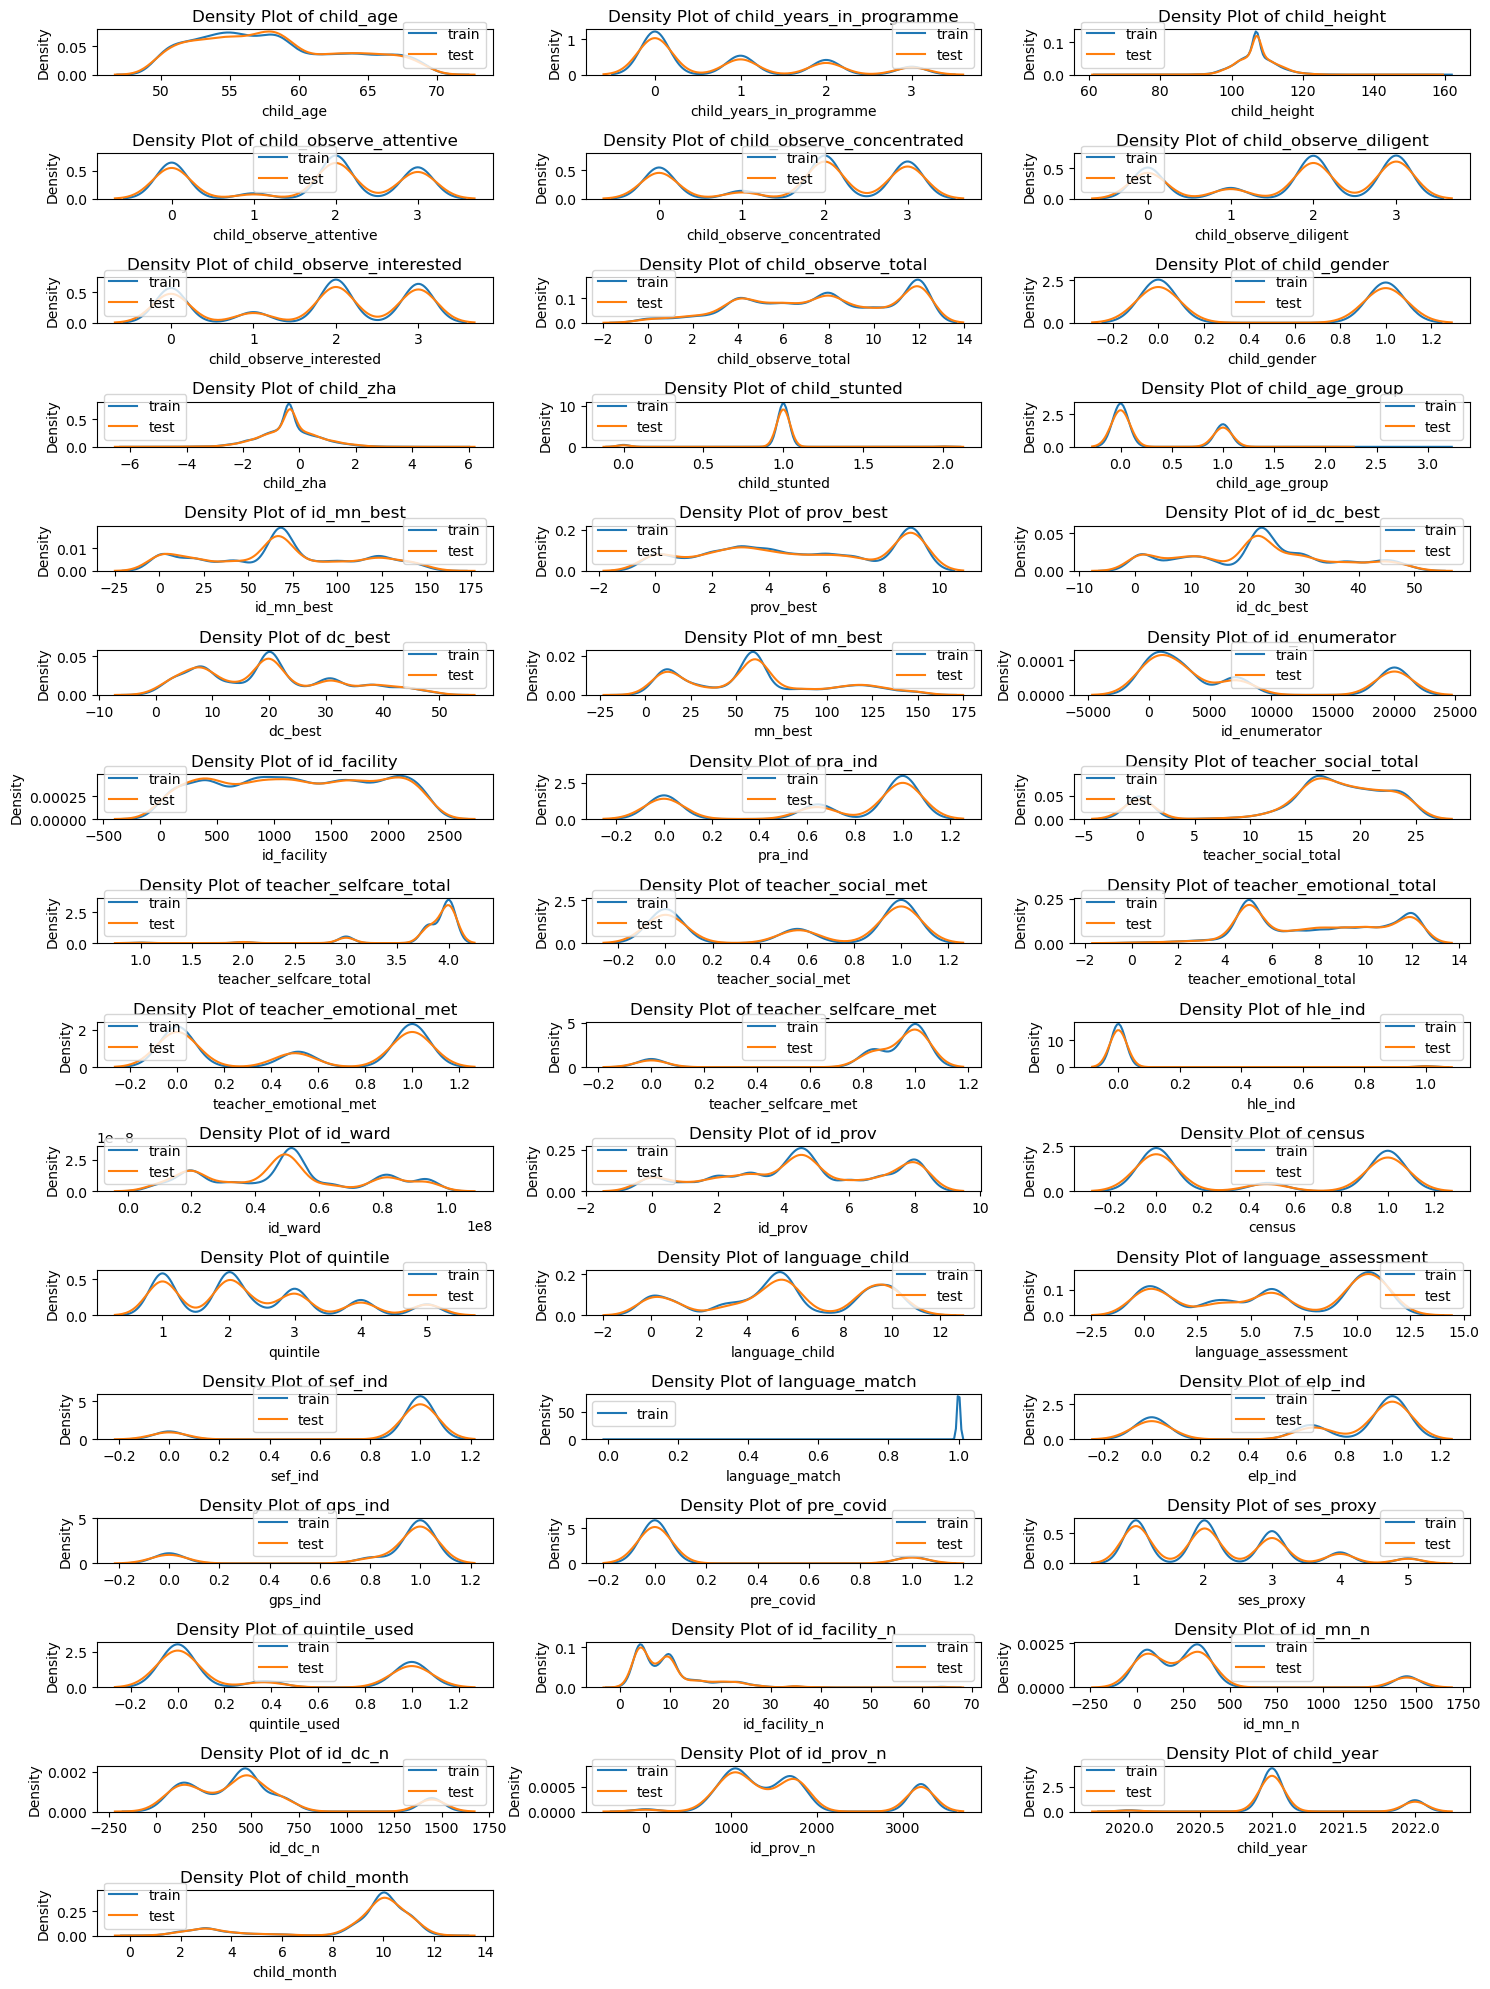

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define the number of columns for the subplot grid
ncols = 3

# Define the number of rows for the subplot grid
nrows = int(np.ceil(len(X.columns) / ncols))

# Create the figure and axes for the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Iterate over the columns
for i, column in enumerate(X.columns):
    if column == 'Label':
        continue

    # Plot the density of each variable with respect to the label (0 or 1)
    ax = axes[i]
    sns.kdeplot(X[column],label='train' ,ax=ax)
    sns.kdeplot(test[column],label='test' ,ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.set_title('Density Plot of ' + column )
    ax.legend()

# Remove the empty subplots from the figure
for i in range(len(X.columns)-1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [33]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7) ]

test.drop(columns=to_drop,inplace=True)
X.drop(columns=to_drop,inplace=True)
X.head()

,child_age,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_total,child_gender,child_stunted,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,id_enumerator,id_facility,pra_ind,teacher_social_total,teacher_selfcare_total,teacher_emotional_total,hle_ind,id_ward,census,quintile,language_child,sef_ind,language_match,gps_ind,ses_proxy,id_facility_n,id_mn_n,id_prov_n,child_year,child_month,child_day_name
0,59.000000,3.0,106.940060,3.0,3.0,3.0,4.0,0.0,1.0,39.00000,2.0,35.0,35.0,28.00000,20005.000000,761.0,0.0,0.0,3.801508,5.0,0.0,7.420104e+07,0.0,2.0,4.0,1.0,1.0,1.0,2.0,7.0,107.000000,1051.0,2022.0,2.0,4.0
1,60.163933,0.0,103.000000,3.0,1.0,3.0,4.0,0.0,1.0,67.86645,3.0,14.0,39.0,59.49082,7103.696893,458.0,0.0,12.0,4.000000,7.0,0.0,5.116381e+07,0.0,4.0,10.0,1.0,1.0,0.0,4.0,24.0,331.552752,1832.0,2021.0,10.0,4.0
2,69.000000,3.0,108.400002,2.0,2.0,3.0,7.0,1.0,1.0,1.00000,9.0,1.0,8.0,11.00000,20001.000000,925.0,0.0,15.0,4.000000,9.0,0.0,1.910008e+07,0.0,4.0,0.0,0.0,1.0,1.0,1.0,8.0,1448.000000,3214.0,2022.0,3.0,0.0
3,53.000000,0.0,98.099998,0.0,0.0,3.0,9.0,1.0,1.0,144.00000,9.0,11.0,5.0,6.00000,2689.000000,308.0,1.0,18.0,4.000000,12.0,0.0,1.020502e+07,1.0,1.0,9.0,1.0,1.0,1.0,3.0,4.0,76.000000,3214.0,2021.0,10.0,6.0
4,57.000000,1.0,114.000000,0.0,0.0,0.0,12.0,0.0,1.0,68.00000,3.0,21.0,21.0,98.00000,542.000000,1749.0,1.0,24.0,4.000000,12.0,0.0,5.290301e+07,0.0,1.0,10.0,1.0,1.0,1.0,1.0,1.0,71.000000,1832.0,2021.0,10.0,6.0


<Axes: ylabel='target'>

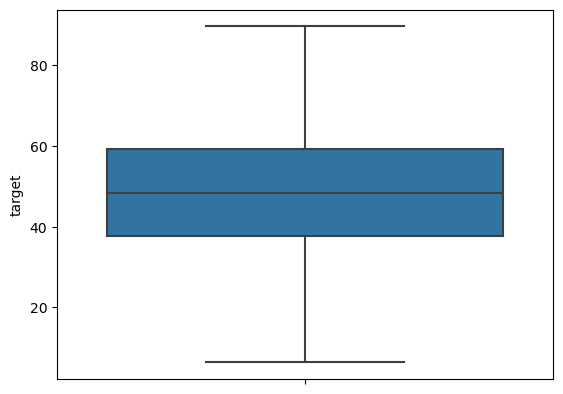

In [34]:
sb.boxplot(data=train,  y='target')

# Feature Engineering

X=X.drop(columns='language_match')
test=test.drop(columns='language_match')

# Group By id_enumerator

In [35]:
train_test=pd.concat([X,test])

In [36]:
train_test=train_test.drop(columns=['sef_ind','sef_ind'])

## median

In [37]:
i=0
    
for col in train_test.columns:
    
        X['newM'+str(i)]=1
        grouped = train_test.groupby(['id_enumerator'])
        mean_x = grouped[col].count()
        X['newM'+str(i)] = X["id_enumerator"].map(mean_x)

        test['newM'+str(i)]=1
        grouped = test.groupby(['id_enumerator'])
        test['newM'+str(i)] = test["id_enumerator"].map(mean_x)
        i+=1

## count

In [38]:
i=0
    
for col in train_test.columns:
    
        X['newC'+str(i)]=1
        grouped = train_test.groupby(['id_enumerator'])
        mean_x = grouped[col].count()
        X['newC'+str(i)] = X["id_enumerator"].map(mean_x)

        test['newC'+str(i)]=1
        grouped = test.groupby(['id_enumerator'])
        test['newC'+str(i)] = test["id_enumerator"].map(mean_x)
        i+=1

## STD

In [39]:
i=0
    
for col in train_test.columns:
        X['newS'+str(i)]=1
        grouped = train_test.groupby(['id_enumerator'])
        mean_x = grouped[col].std()
        X['newS'+str(i)] = X["id_enumerator"].map(mean_x)

        test['newS'+str(i)]=1
        grouped = test.groupby(['id_enumerator'])
        test['newS'+str(i)] = test["id_enumerator"].map(mean_x)
        i+=1

## VAR

In [40]:
i=0
    
for col in train_test.columns:
        X['newVARE'+str(i)]=1
        grouped = train_test.groupby(['id_enumerator'])
        mean_x = grouped[col].var()
        X['newVARE'+str(i)] = X["id_enumerator"].map(mean_x)

        test['newVARE'+str(i)]=1
        grouped = test.groupby(['id_enumerator'])
        test['newVARE'+str(i)] = test["id_enumerator"].map(mean_x)
        i+=1

# Mean

In [41]:
i=0
    
for col in train_test.columns:
        X['newMeanE'+str(i)]=1
        grouped = train_test.groupby(['id_enumerator'])
        mean_x = grouped[col].mean()
        X['newMeanE'+str(i)] = X["id_enumerator"].map(mean_x)

        test['newMeanE'+str(i)]=1
        grouped = test.groupby(['id_enumerator'])
        test['newMeanE'+str(i)] = test["id_enumerator"].map(mean_x)
        i+=1

# Group By X over id_enumerator

## median

In [42]:
for col in train_test.columns:
        X[col+'_id_enum_'+'median']=1
        grouped = train_test.groupby([col])
        mean_x = grouped['id_enumerator'].median()                       
        X[col+'_id_enum_'+'median'] = X[col].map(mean_x)

        test[col+'_id_enum_'+'median']=1
        grouped = test.groupby([col])
        test[col+'_id_enum_'+'median'] = test[col].map(mean_x)       

In [43]:
X.fillna(0,inplace=True)    
test.fillna(0,inplace=True)

# CatBoost

In [56]:
X_train, X_test , y_train, y_test = train_test_split(X, y,test_size=0.1, random_state=0)

catB =  CatBoostRegressor(iterations=1600, learning_rate=0.05, depth=5,colsample_bylevel=0.7, random_seed=0,verbose=100
                        )
catB.fit(X_train, y_train, eval_set=[ (X_test, y_test)], verbose=200)

0:	learn: 14.8233013	test: 14.6198878	best: 14.6198878 (0)	total: 6.88ms	remaining: 11s
200:	learn: 9.3428478	test: 9.6185515	best: 9.6185515 (200)	total: 1.66s	remaining: 11.6s
400:	learn: 8.5718668	test: 9.2208945	best: 9.2201118 (399)	total: 3.27s	remaining: 9.77s
600:	learn: 8.1446004	test: 9.1219987	best: 9.1219987 (600)	total: 4.96s	remaining: 8.25s
800:	learn: 7.8011196	test: 9.0676327	best: 9.0642335 (787)	total: 6.68s	remaining: 6.67s
1000:	learn: 7.5062909	test: 9.0553776	best: 9.0519450 (947)	total: 8.59s	remaining: 5.14s
1200:	learn: 7.2362755	test: 9.0463787	best: 9.0419385 (1158)	total: 10.3s	remaining: 3.42s
1400:	learn: 7.0009424	test: 9.0430403	best: 9.0413876 (1392)	total: 12.1s	remaining: 1.71s
1599:	learn: 6.7816041	test: 9.0507813	best: 9.0396489 (1425)	total: 14.4s	remaining: 0us

bestTest = 9.039648887
bestIteration = 1425

Shrink model to first 1426 iterations.


In [57]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)
losses =[]
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    
    catB.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test, y_test)], verbose=200)
    loss = mse(y_test,catB.predict(X_test), squared=False)
    print(loss)
    losses.append(loss)
print("mean loss:",np.mean(losses))

0:	learn: 14.8541156	test: 14.8541156	test1: 14.5852737	best: 14.5852737 (0)	total: 8.69ms	remaining: 13.9s
200:	learn: 9.3034603	test: 9.3034603	test1: 9.6582989	best: 9.6582989 (200)	total: 2.4s	remaining: 16.7s
400:	learn: 8.5165100	test: 8.5165100	test1: 9.2698871	best: 9.2695674 (399)	total: 4.33s	remaining: 13s
600:	learn: 8.0514844	test: 8.0514844	test1: 9.1593194	best: 9.1593194 (600)	total: 6.15s	remaining: 10.2s
800:	learn: 7.6821443	test: 7.6821443	test1: 9.1237743	best: 9.1197000 (785)	total: 7.95s	remaining: 7.92s
1000:	learn: 7.3591444	test: 7.3591444	test1: 9.1090722	best: 9.1075460 (988)	total: 9.85s	remaining: 5.89s
1200:	learn: 7.0766966	test: 7.0766966	test1: 9.0994746	best: 9.0982048 (1105)	total: 11.8s	remaining: 3.93s
1400:	learn: 6.8304145	test: 6.8304145	test1: 9.0951214	best: 9.0942784 (1396)	total: 13.9s	remaining: 1.97s
1599:	learn: 6.5986157	test: 6.5986157	test1: 9.0955932	best: 9.0922456 (1413)	total: 15.9s	remaining: 0us

bestTest = 9.092245554
bestIterat

In [58]:
X.shape

(8563, 239)

Text(0.5, 1.0, 'Feature Importance')

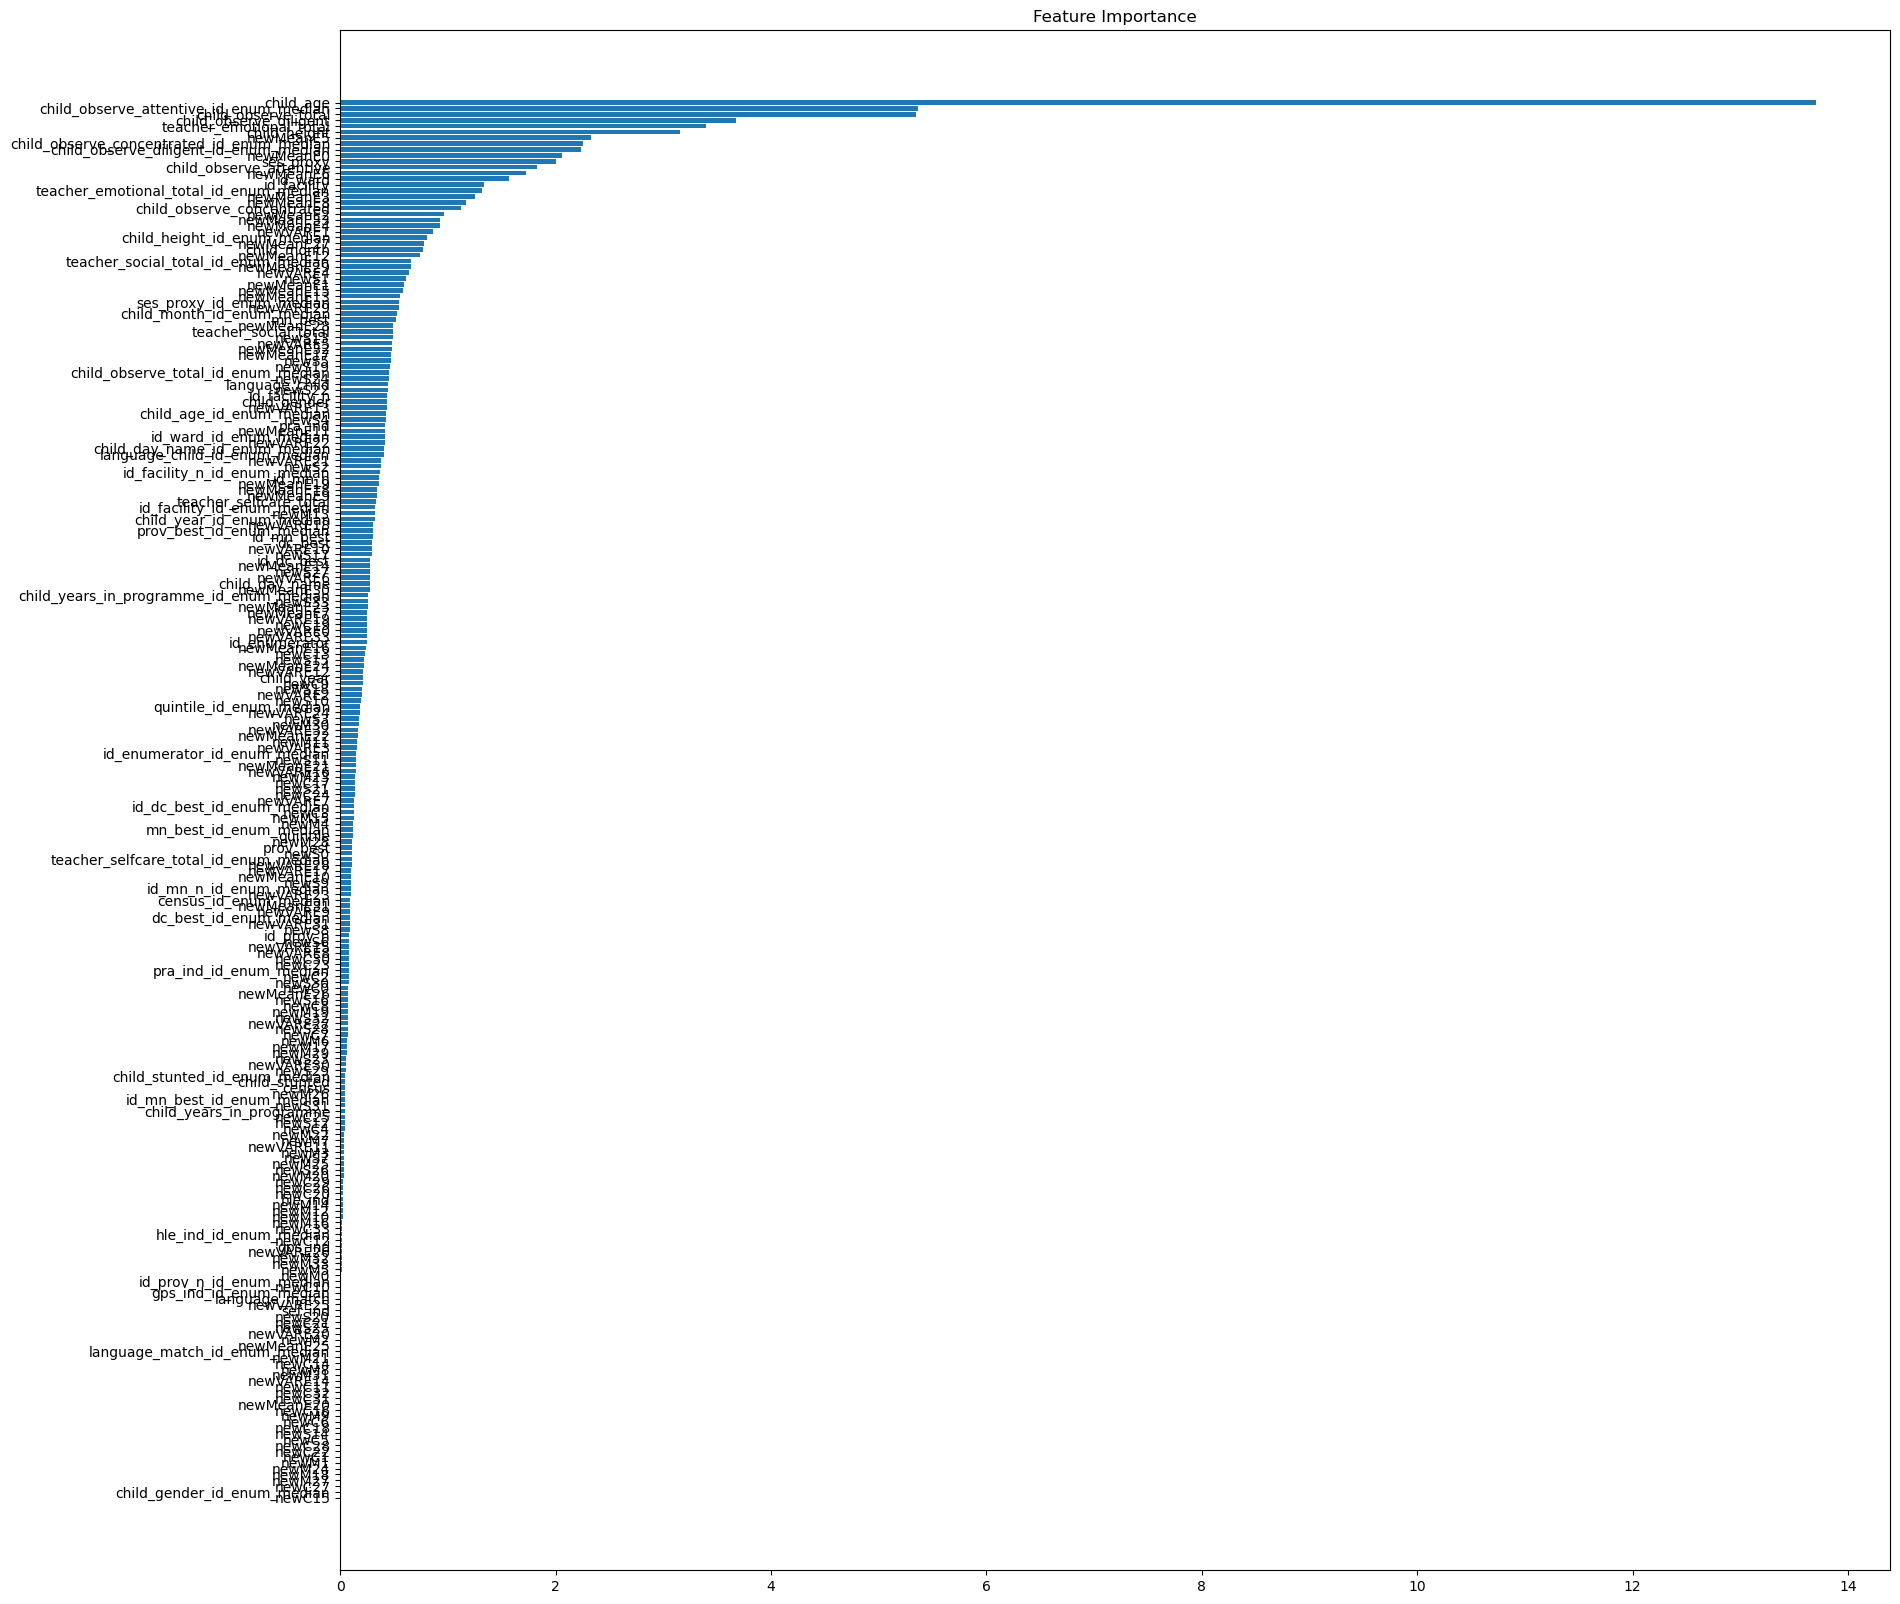

In [59]:
feature_importance = catB.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [60]:
feature_names = X.columns
for idx, importance in enumerate(feature_importance.argsort()[::-1]):
    print("{}. Feature: {}, Importance score: {:.2f}".format(
        idx+1, feature_names[importance], feature_importance[importance]))

1. Feature: child_age, Importance score: 13.70
2. Feature: child_observe_attentive_id_enum_median, Importance score: 5.37
3. Feature: child_observe_total, Importance score: 5.34
4. Feature: child_observe_diligent, Importance score: 3.68
5. Feature: teacher_emotional_total, Importance score: 3.40
6. Feature: child_height, Importance score: 3.16
7. Feature: newMeanE5, Importance score: 2.33
8. Feature: child_observe_concentrated_id_enum_median, Importance score: 2.26
9. Feature: child_observe_diligent_id_enum_median, Importance score: 2.24
10. Feature: newMeanE0, Importance score: 2.06
11. Feature: ses_proxy, Importance score: 2.01
12. Feature: child_observe_attentive, Importance score: 1.83
13. Feature: newMeanE6, Importance score: 1.73
14. Feature: id_ward, Importance score: 1.57
15. Feature: id_facility, Importance score: 1.33
16. Feature: teacher_emotional_total_id_enum_median, Importance score: 1.32
17. Feature: newMeanE3, Importance score: 1.25
18. Feature: newMeanE8, Importance sc

## Delete low coeff features

In [158]:
for idx, importance in enumerate(feature_importance.argsort()[::-1]):
    if (feature_importance[importance]>0.0 and feature_importance[importance]<0.03):
        X.drop(columns=feature_names[importance],inplace=True)
        test.drop(columns=feature_names[importance],inplace=True)

# Linear

In [45]:
# Train a model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [46]:
import eli5
# Preview overall top 10 features
eli5.show_weights(catB, feature_names=list(X.columns))

Weight,Feature
0.1240,child_age
0.0499,child_observe_attentive_id_enum_median
0.0426,child_observe_total
0.0371,child_observe_diligent
0.0348,child_height
0.0336,teacher_emotional_total
0.0278,child_observe_concentrated_id_enum_median
0.0229,child_observe_diligent_id_enum_median
0.0191,ses_proxy
0.0186,newMeanE5


In [47]:
# Select a single/specific prediction
sample = X_train.iloc[[1]]
sample

,child_age,child_years_in_programme,child_height,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_total,child_gender,child_stunted,id_mn_best,prov_best,id_dc_best,dc_best,mn_best,id_enumerator,id_facility,pra_ind,teacher_social_total,teacher_selfcare_total,teacher_emotional_total,hle_ind,id_ward,census,quintile,language_child,sef_ind,language_match,gps_ind,ses_proxy,id_facility_n,id_mn_n,id_prov_n,child_year,child_month,child_day_name,newM0,newM1,newM2,newM3,newM4,newM5,newM6,newM7,newM8,newM9,newM10,newM11,newM12,newM13,newM14,newM15,newM16,newM17,newM18,newM19,newM20,newM21,newM22,newM23,newM24,newM25,newM26,newM27,newM28,newM29,newM30,newM31,newM32,newM33,newC0,newC1,newC2,newC3,newC4,newC5,newC6,newC7,newC8,newC9,newC10,newC11,newC12,newC13,newC14,newC15,newC16,newC17,newC18,newC19,newC20,newC21,newC22,newC23,newC24,newC25,newC26,newC27,newC28,newC29,newC30,newC31,newC32,newC33,newS0,newS1,newS2,newS3,newS4,newS5,newS6,newS7,newS8,newS9,newS10,newS11,newS12,newS13,newS14,newS15,newS16,newS17,newS18,newS19,newS20,newS21,newS22,newS23,newS24,newS25,newS26,newS27,newS28,newS29,newS30,newS31,newS32,newS33,newVARE0,newVARE1,newVARE2,newVARE3,newVARE4,newVARE5,newVARE6,newVARE7,newVARE8,newVARE9,newVARE10,newVARE11,newVARE12,newVARE13,newVARE14,newVARE15,newVARE16,newVARE17,newVARE18,newVARE19,newVARE20,newVARE21,newVARE22,newVARE23,newVARE24,newVARE25,newVARE26,newVARE27,newVARE28,newVARE29,newVARE30,newVARE31,newVARE32,newVARE33,newMeanE0,newMeanE1,newMeanE2,newMeanE3,newMeanE4,newMeanE5,newMeanE6,newMeanE7,newMeanE8,newMeanE9,newMeanE10,newMeanE11,newMeanE12,newMeanE13,newMeanE14,newMeanE15,newMeanE16,newMeanE17,newMeanE18,newMeanE19,newMeanE20,newMeanE21,newMeanE22,newMeanE23,newMeanE24,newMeanE25,newMeanE26,newMeanE27,newMeanE28,newMeanE29,newMeanE30,newMeanE31,newMeanE32,newMeanE33,child_age_id_enum_median,child_years_in_programme_id_enum_median,child_height_id_enum_median,child_observe_attentive_id_enum_median,child_observe_concentrated_id_enum_median,child_observe_diligent_id_enum_median,child_observe_total_id_enum_median,child_gender_id_enum_median,child_stunted_id_enum_median,id_mn_best_id_enum_median,prov_best_id_enum_median,id_dc_best_id_enum_median,dc_best_id_enum_median,mn_best_id_enum_median,id_enumerator_id_enum_median,id_facility_id_enum_median,pra_ind_id_enum_median,teacher_social_total_id_enum_median,teacher_selfcare_total_id_enum_median,teacher_emotional_total_id_enum_median,hle_ind_id_enum_median,id_ward_id_enum_median,census_id_enum_median,quintile_id_enum_median,language_child_id_enum_median,language_match_id_enum_median,gps_ind_id_enum_median,ses_proxy_id_enum_median,id_facility_n_id_enum_median,id_mn_n_id_enum_median,id_prov_n_id_enum_median,child_year_id_enum_median,child_month_id_enum_median,child_day_name_id_enum_median
5172,63.0,3.0,107.0,2.0,3.0,3.0,5.0,1.0,1.0,1.0,9.0,1.0,8.0,11.0,20067.0,1225.0,0.0,20.0,4.0,6.0,0.0,19100032.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,8.0,1448.0,3214.0,2022.0,3.0,5.0,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,3.879945,0.0,5.209844,0.898259,1.13091,1.179478,2.810625,0.501927,0.243149,67.621579,0.0,6.862844,4.242436,51.67234,0.0,449.014104,0.243149,6.358492,0.387343,2.770951,0.0,1.154002e+07,0.243149,1.338201,0.434959,0.0,0.298942,1.139237,7.977426,674.222116,960.798688,0.434959,3.186994,2.121301,15.053974,0.0,27.142474,0.806869,1.278958,1.391168,7.899614,0.251931,0.059122,4572.677995,0.0,47.098628,17.99826,2670.030736,0.0,201613.66538,0.059122,40.430421,0.150035,7.678169,0.0,1.331721e+14,0.059122,1.790782,0.189189,0.0,0.089366,1.29786,63.639318,454575.462305,923134.118082,0.189189,10.156934,4.49992,63.991071,3.0,108.801791,0.4375,0.732143,1.151786,9.785714,0.517857,0.9375,68.372733,9.0,7.375223,7.88659,40.849199,2006

# Preview top 5 predictors for the single/specific prediction
eli5.show_prediction(xg_reg, X_test.iloc[1], feature_names=list(X.columns), show_feature_values=True, top = 5)

In [48]:
# We can get the top 15 features as a pandas dataframe
eli5.explain_prediction_df(estimator=catB, doc=X_test.iloc[1], top = 15)

## Prediction

In [49]:
# Make predictions on the test set
preds = catB.predict(test)
preds

array([60.53475292, 46.22519085, 49.36509095, ..., 39.3496545 ,
       41.30289375, 41.33986753])

In [50]:
# Get the top five features for each predictions
top_predictors = []
for i in range(test.shape[0]):
  predictors = eli5.explain_prediction_df(estimator=model, doc=test.iloc[i], top = 15)
  top_predictors.append(predictors.feature.tolist())

In [51]:
# Prepare your sub file to look like the provided sample submission
ss.head()

,child_id,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,ID_0I0999N6S,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
1,ID_GQ6ONJ4FP,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
2,ID_YZ76CVRW3,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
3,ID_BNINCRXH8,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
4,ID_1U7GDTLRI,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature


In [52]:
# Submission file preparation
predictors = pd.DataFrame(top_predictors, columns = ['feature_' + str(i) for i in range(1,16)])
predictors['target'] = preds
predictors['child_id'] =child_id
predictors = predictors[ss.columns.tolist()]
predictors.head()

,child_id,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,ID_0I0999N6S,60.534753,child_year,newMeanE31,id_enumerator_id_enum_median,newMeanE14,child_age,newMeanE2,newS12,child_height,newMeanE18,newMeanE6,newS13,child_stunted_id_enum_median,newMeanE0,id_enumerator,<BIAS>
1,ID_GQ6ONJ4FP,46.225191,child_year,newMeanE31,child_age,newMeanE2,child_height,child_month,newMeanE18,newS12,newMeanE14,newMeanE6,newS13,child_stunted_id_enum_median,id_enumerator,newMeanE0,<BIAS>
2,ID_YZ76CVRW3,49.365091,child_year,id_enumerator_id_enum_median,newMeanE14,newMeanE31,child_age,newMeanE2,newVARE32,newS1,newVARE1,child_stunted_id_enum_median,newS13,newS32,newMeanE0,id_enumerator,<BIAS>
3,ID_BNINCRXH8,72.805998,child_year,newMeanE31,child_age,newMeanE2,child_height,newMeanE18,child_month,child_observe_total,teacher_emotional_total,newS1,newMeanE15,newMeanE6,child_stunted_id_enum_median,newMeanE0,<BIAS>
4,ID_1U7GDTLRI,43.593465,child_year,newMeanE31,newS29,child_age,newMeanE2,child_height,newMeanE14,id_enumerator_id_enum_median,child_month,child_stunted_id_enum_median,newS13,newVARE29,id_enumerator,newMeanE0,<BIAS>


In [53]:
# Create csv to upload to Zindi for scoring
predictors.to_csv('BaselineSubmission.csv', index = False)